### 字典学习（Dictionary Learning）&& K-SVD算法

字典学习

数学描述如下，

$$\min_{\mathbf{D},\mathbf{X}}\left \|\mathbf{Y}-\mathbf{D}\mathbf{X}\right \|^2_F,\ s.t. \forall i,\left \|x_i\right \|_0\leq T_0, $$

或者，也可以描述为如下，

$$\min\sum_{i}\left \|x_i\right \|_0,\ s.t.\min_{\mathbf{D},\mathbf{X}}\left \|\mathbf{Y}-\mathbf{D}\mathbf{X}\right \|^2_F\leq T_1, $$

注意到，$\left \| x_i\right \| _0$为零阶范数，但在求解过程中为了方便常常用一阶范数代替。

用拉格朗日乘子法可以将上述约束问题转化为如下无约束问题，

$$\min_{\mathbf{D},\mathbf{X}}\left \|\mathbf{Y}-\mathbf{D}\mathbf{X}\right \|^2_F+\lambda\left \|x_i\right \|_1,$$

注意到，这里有两个需要优化的变量$\mathbf{X}$和$\mathbf{D}$，可以交替的固定一个变量优化另一个变量。

假设$\mathbf{X}$已知，记$\mathbf{d}_k$为字典矩阵$\mathbf{D}$的第$k$列向量，$\mathbf{x}^k_T$为查询矩阵$\mathbf{X}$的第$k$行向量，那么有如下推导，

$$\left \|\mathbf{Y}-\mathbf{D}\mathbf{X}\right \|^2_F=\left \|\mathbf{Y}-\sum_{j=1}^{K}\mathbf{d}_j\mathbf{x}_T^j\right \|^2_F=\left \|\left (\mathbf{Y}-\sum_{j\neq 1}\mathbf{d}_j\mathbf{x}_T^j \right )-\mathbf{d}_k\mathbf{x}_T^k\right \|^2_F=\left \| \mathbf{E_k}-\mathbf{d}_k\mathbf{x}_T^k\right \|^2_F, $$

其中，$\mathbf{E_k}=\mathbf{Y}-\sum_{j\neq 1}\mathbf{d}_j\mathbf{x}_T^j$，因此现在的优化目标为，

$$\min_{\mathbf{d}_k,\mathbf{x}_T^k}\left \| \mathbf{E_k}-\mathbf{d}_k\mathbf{x}_T^k\right \|^2_F,$$

注意到，这里在优化求解前应该做进一步的过滤，目的是把$\mathbf{x}_T^k$中已经为$0$的对应位置都过滤掉，而后再对非$0$的位置求最优化问题，因此，将上述最优化问题过滤成如下形式，

$$\min_{\mathbf{d}_k,\mathbf{x}_T^{'k}}\left \| \mathbf{E^{'}_k}-\mathbf{d}_k\mathbf{x}_T^{'k}\right \|^2_F,$$

K-SVD算法
* Step 1：初始化。可以从$\mathbf{Y}$中随机选取$K$个列向量或者取$\mathbf{Y}$的左奇异矩阵的前$K$个列向量初始化$\mathbf{D}^{(0)}$
* Step 2：稀疏编码。利用更上一步的字典矩阵$\mathbf{D}^{(j)}$来获得新的$\mathbf{X}^((j)}$
* Step 3：计算精度，若精度达到要求，转Step 5，否则转Step 4
* Step 4：逐列更新字典矩阵$\mathbf{D}^{(j)}$（如2.0节所讲）
* Step 5：学习完成

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import numpy as np
from sklearn import linear_model

Image shape: (305, 310, 4)


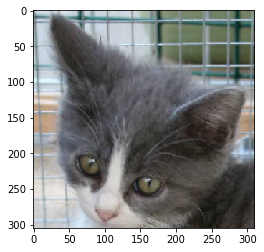

In [2]:
image = mpimg.imread('cat.png')
print('Image shape: {}'.format(image.shape))
plt.imshow(image)

In [3]:
# 将图片reshape成二维
Y = image.reshape(image.shape[0], -1)
print("Y shape: {}".format(Y.shape))

Y shape: (305, 1240)


In [4]:
# KSVD算法
def KSVD(Y, D, X, K):
    for k in range(K):
        index = np.nonzero(X[k, :])[0]
        if len(index) == 0:
            continue
        r = (Y - np.dot(D, X))[:, index]
        U, S, V_T = np.linalg.svd(r, full_matrices=False)
        D[:, k] = U[:, 0]
        for j, xj in enumerate(index):
            X[k, xj] = S[0] * V_T[0, j]
    return D, X

In [12]:
# 训练
def train(Ks, epoches):
    np.random.seed(1024)
    images = []
    for K in Ks:
        # 初始化D，从Y中随机选取K列作为D
        U, _, _ = np.linalg.svd(Y)
        D = U[:, :K]
        for epoch in range(epoches):
            # 每一次更新D之后由OMP算法求得稀疏矩阵X
            X = linear_model.orthogonal_mp((D-D.min())/(D.max()-D.min()), Y)
            # KSVD算法更新D
            D, X = KSVD(Y, D, X, K)
            # 计算损失并输出
            L2_loss = (((Y - np.dot(D, X)) ** 2) ** 0.2).mean()
            print('K: {} | Epoch: {} | L2 loss: {}'.format(K, epoch, L2_loss))
        # 最后一轮更新D之后还需要拟合一下新的X
        X = linear_model.orthogonal_mp((D-D.min())/(D.max()-D.min()), Y)
        # 重构图片
        rebuilded_image = np.clip(np.dot((D-D.min())/(D.max()-D.min()), X).reshape(*image.shape), 0, 1)
        images.append(rebuilded_image)
        print('')
    return images

In [13]:
Ks = [20, 50, 100, 300]
images = train(Ks, epoches=1)

K: 20 | Epoch: 0 | L2 loss: 0.38269000449645535

K: 50 | Epoch: 0 | L2 loss: 0.2793601274112736

K: 100 | Epoch: 0 | L2 loss: 0.2332453565974317

K: 300 | Epoch: 0 | L2 loss: 0.17379884461742612



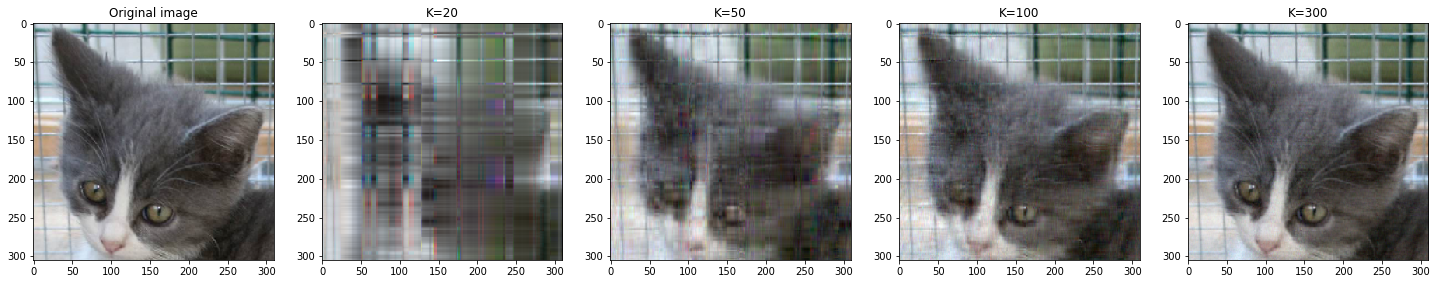

In [14]:
_, axarr = plt.subplots(1, len(Ks)+1, figsize=((len(Ks)+1)*5, 5))
axarr[0].imshow(image)
axarr[0].set_title('Original image')
for i, img in enumerate(images):
    axarr[i+1].imshow(img)
    axarr[i+1].set_title('K={}'.format(Ks[i]))